In [ ]:
!git clone https://github.com/START-Hack/UNEP-STARTHACK22.git
!pip install imbalanced-learn
!pip install lightgbm
!pip install optuna
!pip install pycaret

<h2><center> Welcome to the Landslide Prediction Challenge</h2></center>

A landslide is the movement of a mass of rock, debris, or earth(soil) down a slope. As a common natural hazard, it can lead to significant losses of human lives and properties.


Hong Kong, one of the hilly and densely populated cities in the world, is frequently affected by extreme rainstorms, making it highly susceptible to rain-induced natural terrain landslides

<img src = "https://drive.google.com/uc?export=view&id=1-8sSI75AG3HM89nDJEwo6_KJbAEUXS-r">

The common practice of identifying landslides is visual interpretation which, however, is labor-intensive and time-consuming.

***Thus, this hack will focus on automating the landslide identification process using artificial intelligence techniques***

This will be achieved by using high-resolution terrain information to perform the terrain-based landslide identification. Other auxiliary data such as the lithology of the surface materials and rainfall intensification factor are also provided.


Table of contents:

1. [Import relevant libraries](#Libraries)
2. [Load files](#Load)
3. [Preview files](#Preview)
4. [Data dictionary](#Dictionary)
5. [Data exploration](#Exploration)
6. [Target distribution](#Target)
7. [Outliers](#Outliers)
8. [Correlations](#Correlations)
9. [Model training](#Model)
10. [Test set predictions](#Predictions)
11. [Creating a submission file](#Submission)
12. [Tips to improve model performance](#Tips)

<a name = "Libraries"></a>
## 1. Import relevant libraries

In [ ]:
# Import general libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

# Import preprocessing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from imblearn.over_sampling import SMOTE

# Import modelling libraries
from sklearn.metrics import f1_score, classification_report,confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import lightgbm
import xgboost
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
import optuna
import pycaret
from pycaret.classification import *

<a name = "Load"></a>
## 2. Load files

In [ ]:
# Read files to pandas dataframes
train = pd.read_csv('UNEP-STARTHACK22/Dataset/Train.csv')
test = pd.read_csv('UNEP-STARTHACK22/Dataset/Test.csv')
sample_submission = pd.read_csv('UNEP-STARTHACK22/Dataset/Sample submission.csv')

<a name = "Preview"></a>
## 3. Preview files

In [ ]:
# Check the first five rows of the train set
train.head()

,Sample_ID,1_elevation,2_elevation,3_elevation,4_elevation,5_elevation,6_elevation,7_elevation,8_elevation,9_elevation,10_elevation,11_elevation,12_elevation,13_elevation,14_elevation,15_elevation,16_elevation,17_elevation,18_elevation,19_elevation,20_elevation,21_elevation,22_elevation,23_elevation,24_elevation,25_elevation,1_slope,2_slope,3_slope,4_slope,5_slope,6_slope,7_slope,8_slope,9_slope,10_slope,11_slope,12_slope,13_slope,14_slope,15_slope,16_slope,17_slope,18_slope,19_slope,20_slope,21_slope,22_slope,23_slope,24_slope,25_slope,1_aspect,2_aspect,3_aspect,4_aspect,5_aspect,6_aspect,7_aspect,8_aspect,9_aspect,10_aspect,11_aspect,12_aspect,13_aspect,14_aspect,15_aspect,16_aspect,17_aspect,18_aspect,19_aspect,20_aspect,21_aspect,22_aspect,23_aspect,24_aspect,25_aspect,1_placurv,2_placurv,3_placurv,4_placurv,5_placurv,6_placurv,7_placurv,8_placurv,9_placurv,10_placurv,11_placurv,12_placurv,13_placurv,14_placurv,15_placurv,16_placurv,17_placurv,18_placurv,19_placurv,20_placurv,21_placurv,22_placurv,23_placurv,24_placurv,25_placurv,1_procurv,2_procurv,3_procurv,4_procurv,5_procurv,6_procurv,7_procurv,8_procurv,9_procurv,10_procurv,11_procurv,12_procurv,13_procurv,14_procurv,15_procurv,16_procurv,17_procurv,18_procurv,19_procurv,20_procurv,21_procurv,22_procurv,23_procurv,24_procurv,25_procurv,1_lsfactor,2_lsfactor,3_lsfactor,4_lsfactor,5_lsfactor,6_lsfactor,7_lsfactor,8_lsfactor,9_lsfactor,10_lsfactor,11_lsfactor,12_lsfactor,13_lsfactor,14_lsfactor,15_lsfactor,16_lsfactor,17_lsfactor,18_lsfactor,19_lsfactor,20_lsfactor,21_lsfactor,22_lsfactor,23_lsfactor,24_lsfactor,25_lsfactor,1_twi,2_twi,3_twi,4_twi,5_twi,6_twi,7_twi,8_twi,9_twi,10_twi,11_twi,12_twi,13_twi,14_twi,15_twi,16_twi,17_twi,18_twi,19_twi,20_twi,21_twi,22_twi,23_twi,24_twi,25_twi,1_geology,2_geology,3_geology,4_geology,5_geology,6_geology,7_geology,8_geology,9_geology,10_geology,11_geology,12_geology,13_geology,14_geology,15_geology,16_geology,17_geology,18_geology,19_geology,20_geology,21_geology,22_geology,23_geology,24_geology,25_geology,1_sdoif,2_sdoif,3_sdoif,4_sdoif,5_sdoif,6_sdoif,7_sdoif,8_sdoif,9_sdoif,10_sdoif,11_sdoif,12_sdoif,13_sdoif,14_sdoif,15_sdoif,16_sdoif,17_sdoif,18_sdoif,19_sdoif,20_sdoif,21_sdoif,22_sdoif,23_sdoif,24_sdoif,25_sdoif,Label
0,1,130,129,127,126,123,126,125,124,122,119,122,121,119,117,115,119,117,115,114,112,116,114,113,111,110,35.26439,37.29208,33.85452,35.79576,40.31554,38.87666,39.50971,40.51059,45.83452,45.00000,36.05503,40.51059,44.56372,41.81031,38.87666,33.85452,38.87666,33.85452,33.85452,32.63194,32.63194,30.24626,30.24626,30.24626,30.24626,98.1301,113.1986,116.5650,123.6901,135.0000,97.12502,104.0362,110.5560,119.0546,126.8699,105.9454,110.5560,113.9625,116.5650,119.7449,116.5650,119.7449,116.5650,116.5650,128.6598,128.6598,120.9638,120.9638,120.9638,120.9638,0.038514,0.029463,0.031405,0.025771,0.010453,0.028321,0.027360,0.019831,0.009338,0.008806,0.021451,0.021244,0.017273,0.006708,-0.008671,0.023851,0.012586,-0.004249,0.003646,-0.006809,0.013328,0.005337,0.007039,-0.017753,-0.007777,0.013903,0.014674,0.018249,0.018368,0.003341,0.002023,0.005743,0.002238,-0.003820,-0.003302,-0.002141,0.003585,0.002025,-0.012269,-0.027184,0.000977,-0.012630,-0.031644,-0.025683,-0.037371,-0.018934,-0.021875,-0.023553,-0.048495,-0.039092,8.045186,8.333038,7.819405,8.032228,9.818933,9.295772,9.375107,9.499450,10.922910,11.001900,9.339861,9.883230,11.035840,10.298030,9.618946,8.703197,10.175750,8.651121,8.251134,8.074524,8.519887,7.989215,7.634287,7.804186,7.219216,3.173340,2.961406,3.315935,3.061250,3.246914,3.221661,3.153512,3.048637,2.915506,3.073973,3.765278,3.246664,3.154479,3.237765,3.392537,3.851345,3.673898,3.821337,3.584646,3.734637,4.003083,4.218082,3.990867,4.100921,3.715154,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,1.281767,1.281743,1.281708,1.281684,1.281649,1.281780,1.281757,1.281721,1.281698,1.281662,1.281789,1.281765,1.281730,1.281707,1.281671,1.281802,1.281779,1.281743,1.281720,1.281684,1.281811,1.281788,1.281752,1.281

In [ ]:
# Check the first five rows of the test set
test.head()

,Sample_ID,1_elevation,2_elevation,3_elevation,4_elevation,5_elevation,6_elevation,7_elevation,8_elevation,9_elevation,10_elevation,11_elevation,12_elevation,13_elevation,14_elevation,15_elevation,16_elevation,17_elevation,18_elevation,19_elevation,20_elevation,21_elevation,22_elevation,23_elevation,24_elevation,25_elevation,1_slope,2_slope,3_slope,4_slope,5_slope,6_slope,7_slope,8_slope,9_slope,10_slope,11_slope,12_slope,13_slope,14_slope,15_slope,16_slope,17_slope,18_slope,19_slope,20_slope,21_slope,22_slope,23_slope,24_slope,25_slope,1_aspect,2_aspect,3_aspect,4_aspect,5_aspect,6_aspect,7_aspect,8_aspect,9_aspect,10_aspect,11_aspect,12_aspect,13_aspect,14_aspect,15_aspect,16_aspect,17_aspect,18_aspect,19_aspect,20_aspect,21_aspect,22_aspect,23_aspect,24_aspect,25_aspect,1_placurv,2_placurv,3_placurv,4_placurv,5_placurv,6_placurv,7_placurv,8_placurv,9_placurv,10_placurv,11_placurv,12_placurv,13_placurv,14_placurv,15_placurv,16_placurv,17_placurv,18_placurv,19_placurv,20_placurv,21_placurv,22_placurv,23_placurv,24_placurv,25_placurv,1_procurv,2_procurv,3_procurv,4_procurv,5_procurv,6_procurv,7_procurv,8_procurv,9_procurv,10_procurv,11_procurv,12_procurv,13_procurv,14_procurv,15_procurv,16_procurv,17_procurv,18_procurv,19_procurv,20_procurv,21_procurv,22_procurv,23_procurv,24_procurv,25_procurv,1_lsfactor,2_lsfactor,3_lsfactor,4_lsfactor,5_lsfactor,6_lsfactor,7_lsfactor,8_lsfactor,9_lsfactor,10_lsfactor,11_lsfactor,12_lsfactor,13_lsfactor,14_lsfactor,15_lsfactor,16_lsfactor,17_lsfactor,18_lsfactor,19_lsfactor,20_lsfactor,21_lsfactor,22_lsfactor,23_lsfactor,24_lsfactor,25_lsfactor,1_twi,2_twi,3_twi,4_twi,5_twi,6_twi,7_twi,8_twi,9_twi,10_twi,11_twi,12_twi,13_twi,14_twi,15_twi,16_twi,17_twi,18_twi,19_twi,20_twi,21_twi,22_twi,23_twi,24_twi,25_twi,1_geology,2_geology,3_geology,4_geology,5_geology,6_geology,7_geology,8_geology,9_geology,10_geology,11_geology,12_geology,13_geology,14_geology,15_geology,16_geology,17_geology,18_geology,19_geology,20_geology,21_geology,22_geology,23_geology,24_geology,25_geology,1_sdoif,2_sdoif,3_sdoif,4_sdoif,5_sdoif,6_sdoif,7_sdoif,8_sdoif,9_sdoif,10_sdoif,11_sdoif,12_sdoif,13_sdoif,14_sdoif,15_sdoif,16_sdoif,17_sdoif,18_sdoif,19_sdoif,20_sdoif,21_sdoif,22_sdoif,23_sdoif,24_sdoif,25_sdoif
0,10865,111,109,109,110,112,117,114,113,112,113,120,120,118,116,115,122,122,122,121,120,122,122,121,121,123,45.83452,36.055030,27.01712,22.98977,27.01712,43.49152,49.490830,42.67464,30.96376,22.98977,27.017120,39.509710,44.56372,43.49152,35.26439,12.604380,11.309930,17.54840,28.30320,38.87666,5.710593,5.710593,8.049467,12.60438,26.56505,240.9454,254.05460,281.30990,315.00000,348.69010,251.56500,250.01690,257.47120,270.00000,315.00000,281.30990,255.96380,246.03750,251.56500,278.130100,296.56510,270.00000,251.56500,248.19860,277.125000,360.00000,180.00000,135.00000,333.43490,306.86990,0.035766,-0.013152,-0.037572,-0.062401,-0.055791,0.027593,0.002834,-0.038738,-0.052596,-0.035428,0.031410,0.010285,-0.030370,-0.047145,-0.030835,0.060269,0.010774,-0.009391,-0.030129,-0.029237,0.088753,0.075792,0.023841,-0.001485,-0.010110,-0.016483,-0.044767,-0.042420,-0.053476,-0.043530,0.008279,0.002710,-0.010917,-0.013603,-0.011500,0.026537,0.017282,-0.005495,-0.016250,-0.016121,0.074879,0.055460,0.042507,0.019065,-0.003870,0.024342,0.042834,0.056148,0.040106,0.021167,9.667106,8.181493,7.782584,8.776177,10.954420,8.896092,11.257830,10.227420,10.278770,8.030625,5.094675,8.138618,10.002860,11.459460,9.746919,1.718303,1.830190,4.348740,5.784863,10.840700,0.664827,0.000081,0.000261,0.846584,4.815838,2.682646,4.814003,6.252043,6.667844,6.602260,2.240095,2.561107,3.066897,5.311826,6.215635,2.774525,2.446323,2.663095,3.096692,4.132727,2.930157,4.044015,3.533233,2.135064,4.028785,4.076646,8.517193,9.857834,5.307338,3.319677,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1.310570,1.310638,1.310684,1.310752,1.310797,1.310388,1.310456,1.310502,1.310570,1.310616,1.310266,1.310335,1.310381,1.310449,1.310495,1.310084,1.310153,1.310199,1.310267,

In [ ]:
# Check how the submission file should look like
sample_submission.head()

,Sample_ID,Label
0,10865,0
1,10866,0
2,10867,0
3,10868,0
4,10869,0


<a name = "Dictionary"></a>
## 4. Data Dictionary
<figure>
<img src = "https://drive.google.com/uc?export=view&id=1T_XBSH6ozmhGiDz_nL4bQvvonHUpbCfW" height = "200">
<img src = "https://drive.google.com/uc?export=view&id=13nSrrIowiFPjAgiR--Nd4cHLVwvXFaFj" height = "400">

In [ ]:
# Check shape and size of train and test set
train.shape, test.shape, sample_submission.shape

((10864, 227), (5430, 226), (5430, 2))

<a name = "Exploration"></a>
## 5. Data exploration

In [ ]:
# Check statistical summaries of the train set
train.describe()

,Sample_ID,1_elevation,2_elevation,3_elevation,4_elevation,5_elevation,6_elevation,7_elevation,8_elevation,9_elevation,10_elevation,11_elevation,12_elevation,13_elevation,14_elevation,15_elevation,16_elevation,17_elevation,18_elevation,19_elevation,20_elevation,21_elevation,22_elevation,23_elevation,24_elevation,25_elevation,1_slope,2_slope,3_slope,4_slope,5_slope,6_slope,7_slope,8_slope,9_slope,10_slope,11_slope,12_slope,13_slope,14_slope,15_slope,16_slope,17_slope,18_slope,19_slope,20_slope,21_slope,22_slope,23_slope,24_slope,25_slope,1_aspect,2_aspect,3_aspect,4_aspect,5_aspect,6_aspect,7_aspect,8_aspect,9_aspect,10_aspect,11_aspect,12_aspect,13_aspect,14_aspect,15_aspect,16_aspect,17_aspect,18_aspect,19_aspect,20_aspect,21_aspect,22_aspect,23_aspect,24_aspect,25_aspect,1_placurv,2_placurv,3_placurv,4_placurv,5_placurv,6_placurv,7_placurv,8_placurv,9_placurv,10_placurv,11_placurv,12_placurv,13_placurv,14_placurv,15_placurv,16_placurv,17_placurv,18_placurv,19_placurv,20_placurv,21_placurv,22_placurv,23_placurv,24_placurv,25_placurv,1_procurv,2_procurv,3_procurv,4_procurv,5_procurv,6_procurv,7_procurv,8_procurv,9_procurv,10_procurv,11_procurv,12_procurv,13_procurv,14_procurv,15_procurv,16_procurv,17_procurv,18_procurv,19_procurv,20_procurv,21_procurv,22_procurv,23_procurv,24_procurv,25_procurv,1_lsfactor,2_lsfactor,3_lsfactor,4_lsfactor,5_lsfactor,6_lsfactor,7_lsfactor,8_lsfactor,9_lsfactor,10_lsfactor,11_lsfactor,12_lsfactor,13_lsfactor,14_lsfactor,15_lsfactor,16_lsfactor,17_lsfactor,18_lsfactor,19_lsfactor,20_lsfactor,21_lsfactor,22_lsfactor,23_lsfactor,24_lsfactor,25_lsfactor,1_twi,2_twi,3_twi,4_twi,5_twi,6_twi,7_twi,8_twi,9_twi,10_twi,11_twi,12_twi,13_twi,14_twi,15_twi,16_twi,17_twi,18_twi,19_twi,20_twi,21_twi,22_twi,23_twi,24_twi,25_twi,1_geology,2_geology,3_geology,4_geology,5_geology,6_geology,7_geology,8_geology,9_geology,10_geology,11_geology,12_geology,13_geology,14_geology,15_geology,16_geology,17_geology,18_geology,19_geology,20_geology,21_geology,22_geology,23_geology,24_geology,25_geology,1_sdoif,2_sdoif,3_sdoif,4_sdoif,5_sdoif,6_sdoif,7_sdoif,8_sdoif,9_sdoif,10_sdoif,11_sdoif,12_sdoif,13_sdoif,14_sdoif,15_sdoif,16_sdoif,17_sdoif,18_sdoif,19_sdoif,20_sdoif,21_sdoif,22_sdoif,23_sdoif,24_sdoif,25_sdoif,Label
count,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,1086

In [ ]:
train.head()

,Sample_ID,1_elevation,2_elevation,3_elevation,4_elevation,5_elevation,6_elevation,7_elevation,8_elevation,9_elevation,10_elevation,11_elevation,12_elevation,13_elevation,14_elevation,15_elevation,16_elevation,17_elevation,18_elevation,19_elevation,20_elevation,21_elevation,22_elevation,23_elevation,24_elevation,25_elevation,1_slope,2_slope,3_slope,4_slope,5_slope,6_slope,7_slope,8_slope,9_slope,10_slope,11_slope,12_slope,13_slope,14_slope,15_slope,16_slope,17_slope,18_slope,19_slope,20_slope,21_slope,22_slope,23_slope,24_slope,25_slope,1_aspect,2_aspect,3_aspect,4_aspect,5_aspect,6_aspect,7_aspect,8_aspect,9_aspect,10_aspect,11_aspect,12_aspect,13_aspect,14_aspect,15_aspect,16_aspect,17_aspect,18_aspect,19_aspect,20_aspect,21_aspect,22_aspect,23_aspect,24_aspect,25_aspect,1_placurv,2_placurv,3_placurv,4_placurv,5_placurv,6_placurv,7_placurv,8_placurv,9_placurv,10_placurv,11_placurv,12_placurv,13_placurv,14_placurv,15_placurv,16_placurv,17_placurv,18_placurv,19_placurv,20_placurv,21_placurv,22_placurv,23_placurv,24_placurv,25_placurv,1_procurv,2_procurv,3_procurv,4_procurv,5_procurv,6_procurv,7_procurv,8_procurv,9_procurv,10_procurv,11_procurv,12_procurv,13_procurv,14_procurv,15_procurv,16_procurv,17_procurv,18_procurv,19_procurv,20_procurv,21_procurv,22_procurv,23_procurv,24_procurv,25_procurv,1_lsfactor,2_lsfactor,3_lsfactor,4_lsfactor,5_lsfactor,6_lsfactor,7_lsfactor,8_lsfactor,9_lsfactor,10_lsfactor,11_lsfactor,12_lsfactor,13_lsfactor,14_lsfactor,15_lsfactor,16_lsfactor,17_lsfactor,18_lsfactor,19_lsfactor,20_lsfactor,21_lsfactor,22_lsfactor,23_lsfactor,24_lsfactor,25_lsfactor,1_twi,2_twi,3_twi,4_twi,5_twi,6_twi,7_twi,8_twi,9_twi,10_twi,11_twi,12_twi,13_twi,14_twi,15_twi,16_twi,17_twi,18_twi,19_twi,20_twi,21_twi,22_twi,23_twi,24_twi,25_twi,1_geology,2_geology,3_geology,4_geology,5_geology,6_geology,7_geology,8_geology,9_geology,10_geology,11_geology,12_geology,13_geology,14_geology,15_geology,16_geology,17_geology,18_geology,19_geology,20_geology,21_geology,22_geology,23_geology,24_geology,25_geology,1_sdoif,2_sdoif,3_sdoif,4_sdoif,5_sdoif,6_sdoif,7_sdoif,8_sdoif,9_sdoif,10_sdoif,11_sdoif,12_sdoif,13_sdoif,14_sdoif,15_sdoif,16_sdoif,17_sdoif,18_sdoif,19_sdoif,20_sdoif,21_sdoif,22_sdoif,23_sdoif,24_sdoif,25_sdoif,Label
0,1,130,129,127,126,123,126,125,124,122,119,122,121,119,117,115,119,117,115,114,112,116,114,113,111,110,35.26439,37.29208,33.85452,35.79576,40.31554,38.87666,39.50971,40.51059,45.83452,45.00000,36.05503,40.51059,44.56372,41.81031,38.87666,33.85452,38.87666,33.85452,33.85452,32.63194,32.63194,30.24626,30.24626,30.24626,30.24626,98.1301,113.1986,116.5650,123.6901,135.0000,97.12502,104.0362,110.5560,119.0546,126.8699,105.9454,110.5560,113.9625,116.5650,119.7449,116.5650,119.7449,116.5650,116.5650,128.6598,128.6598,120.9638,120.9638,120.9638,120.9638,0.038514,0.029463,0.031405,0.025771,0.010453,0.028321,0.027360,0.019831,0.009338,0.008806,0.021451,0.021244,0.017273,0.006708,-0.008671,0.023851,0.012586,-0.004249,0.003646,-0.006809,0.013328,0.005337,0.007039,-0.017753,-0.007777,0.013903,0.014674,0.018249,0.018368,0.003341,0.002023,0.005743,0.002238,-0.003820,-0.003302,-0.002141,0.003585,0.002025,-0.012269,-0.027184,0.000977,-0.012630,-0.031644,-0.025683,-0.037371,-0.018934,-0.021875,-0.023553,-0.048495,-0.039092,8.045186,8.333038,7.819405,8.032228,9.818933,9.295772,9.375107,9.499450,10.922910,11.001900,9.339861,9.883230,11.035840,10.298030,9.618946,8.703197,10.175750,8.651121,8.251134,8.074524,8.519887,7.989215,7.634287,7.804186,7.219216,3.173340,2.961406,3.315935,3.061250,3.246914,3.221661,3.153512,3.048637,2.915506,3.073973,3.765278,3.246664,3.154479,3.237765,3.392537,3.851345,3.673898,3.821337,3.584646,3.734637,4.003083,4.218082,3.990867,4.100921,3.715154,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,1.281767,1.281743,1.281708,1.281684,1.281649,1.281780,1.281757,1.281721,1.281698,1.281662,1.281789,1.281765,1.281730,1.281707,1.281671,1.281802,1.281779,1.281743,1.281720,1.281684,1.281811,1.281788,1.281752,1.281

<Figure size 1440x864 with 0 Axes>

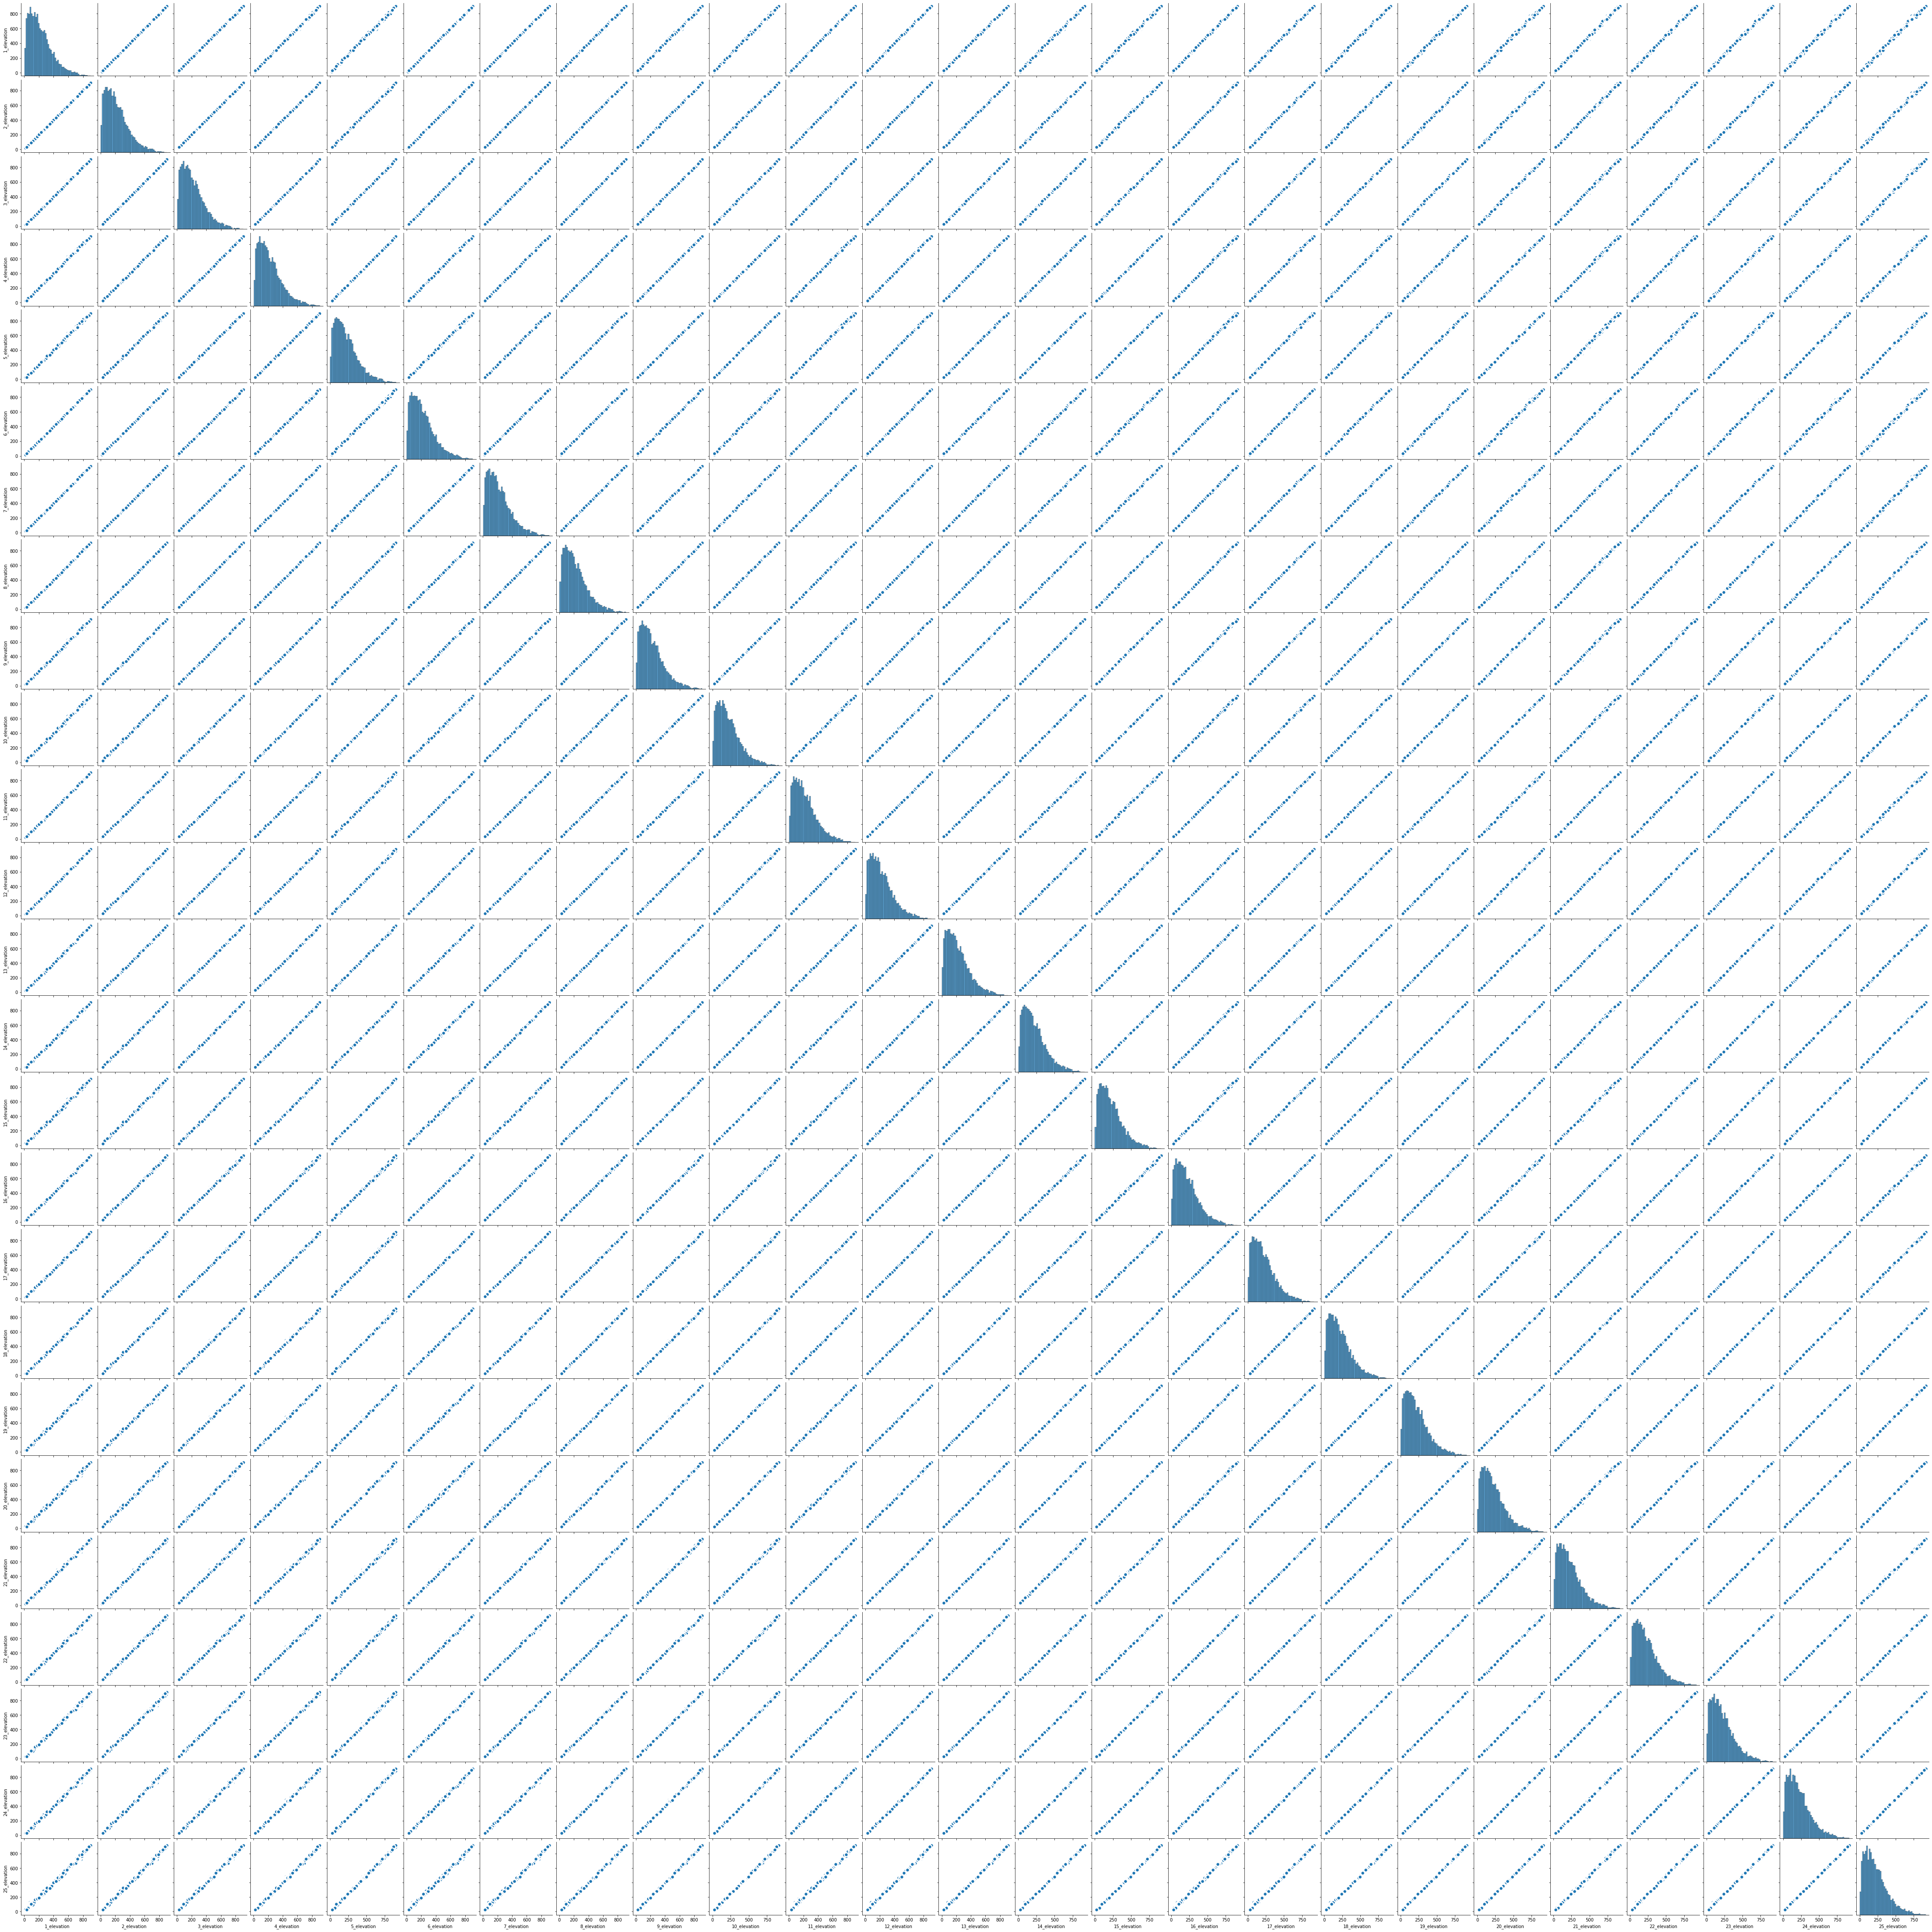

In [ ]:
# Elevation correlations
plt.figure(figsize = (20, 12))
sample_elevations = [col for col in train.columns if col.endswith('elevation')]
sns.pairplot(train[sample_elevations], kind="scatter", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

 - There is a very high correlation between elevation features extracted from the same location

In [ ]:
# Check statistical summaries of the test set
test.describe()

,Sample_ID,1_elevation,2_elevation,3_elevation,4_elevation,5_elevation,6_elevation,7_elevation,8_elevation,9_elevation,10_elevation,11_elevation,12_elevation,13_elevation,14_elevation,15_elevation,16_elevation,17_elevation,18_elevation,19_elevation,20_elevation,21_elevation,22_elevation,23_elevation,24_elevation,25_elevation,1_slope,2_slope,3_slope,4_slope,5_slope,6_slope,7_slope,8_slope,9_slope,10_slope,11_slope,12_slope,13_slope,14_slope,15_slope,16_slope,17_slope,18_slope,19_slope,20_slope,21_slope,22_slope,23_slope,24_slope,25_slope,1_aspect,2_aspect,3_aspect,4_aspect,5_aspect,6_aspect,7_aspect,8_aspect,9_aspect,10_aspect,11_aspect,12_aspect,13_aspect,14_aspect,15_aspect,16_aspect,17_aspect,18_aspect,19_aspect,20_aspect,21_aspect,22_aspect,23_aspect,24_aspect,25_aspect,1_placurv,2_placurv,3_placurv,4_placurv,5_placurv,6_placurv,7_placurv,8_placurv,9_placurv,10_placurv,11_placurv,12_placurv,13_placurv,14_placurv,15_placurv,16_placurv,17_placurv,18_placurv,19_placurv,20_placurv,21_placurv,22_placurv,23_placurv,24_placurv,25_placurv,1_procurv,2_procurv,3_procurv,4_procurv,5_procurv,6_procurv,7_procurv,8_procurv,9_procurv,10_procurv,11_procurv,12_procurv,13_procurv,14_procurv,15_procurv,16_procurv,17_procurv,18_procurv,19_procurv,20_procurv,21_procurv,22_procurv,23_procurv,24_procurv,25_procurv,1_lsfactor,2_lsfactor,3_lsfactor,4_lsfactor,5_lsfactor,6_lsfactor,7_lsfactor,8_lsfactor,9_lsfactor,10_lsfactor,11_lsfactor,12_lsfactor,13_lsfactor,14_lsfactor,15_lsfactor,16_lsfactor,17_lsfactor,18_lsfactor,19_lsfactor,20_lsfactor,21_lsfactor,22_lsfactor,23_lsfactor,24_lsfactor,25_lsfactor,1_twi,2_twi,3_twi,4_twi,5_twi,6_twi,7_twi,8_twi,9_twi,10_twi,11_twi,12_twi,13_twi,14_twi,15_twi,16_twi,17_twi,18_twi,19_twi,20_twi,21_twi,22_twi,23_twi,24_twi,25_twi,1_geology,2_geology,3_geology,4_geology,5_geology,6_geology,7_geology,8_geology,9_geology,10_geology,11_geology,12_geology,13_geology,14_geology,15_geology,16_geology,17_geology,18_geology,19_geology,20_geology,21_geology,22_geology,23_geology,24_geology,25_geology,1_sdoif,2_sdoif,3_sdoif,4_sdoif,5_sdoif,6_sdoif,7_sdoif,8_sdoif,9_sdoif,10_sdoif,11_sdoif,12_sdoif,13_sdoif,14_sdoif,15_sdoif,16_sdoif,17_sdoif,18_sdoif,19_sdoif,20_sdoif,21_sdoif,22_sdoif,23_sdoif,24_sdoif,25_sdoif
count,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5.430000e+03,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5.430000e+03,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.000000,5430.0000

In [ ]:
test.head()

,Sample_ID,1_elevation,2_elevation,3_elevation,4_elevation,5_elevation,6_elevation,7_elevation,8_elevation,9_elevation,10_elevation,11_elevation,12_elevation,13_elevation,14_elevation,15_elevation,16_elevation,17_elevation,18_elevation,19_elevation,20_elevation,21_elevation,22_elevation,23_elevation,24_elevation,25_elevation,1_slope,2_slope,3_slope,4_slope,5_slope,6_slope,7_slope,8_slope,9_slope,10_slope,11_slope,12_slope,13_slope,14_slope,15_slope,16_slope,17_slope,18_slope,19_slope,20_slope,21_slope,22_slope,23_slope,24_slope,25_slope,1_aspect,2_aspect,3_aspect,4_aspect,5_aspect,6_aspect,7_aspect,8_aspect,9_aspect,10_aspect,11_aspect,12_aspect,13_aspect,14_aspect,15_aspect,16_aspect,17_aspect,18_aspect,19_aspect,20_aspect,21_aspect,22_aspect,23_aspect,24_aspect,25_aspect,1_placurv,2_placurv,3_placurv,4_placurv,5_placurv,6_placurv,7_placurv,8_placurv,9_placurv,10_placurv,11_placurv,12_placurv,13_placurv,14_placurv,15_placurv,16_placurv,17_placurv,18_placurv,19_placurv,20_placurv,21_placurv,22_placurv,23_placurv,24_placurv,25_placurv,1_procurv,2_procurv,3_procurv,4_procurv,5_procurv,6_procurv,7_procurv,8_procurv,9_procurv,10_procurv,11_procurv,12_procurv,13_procurv,14_procurv,15_procurv,16_procurv,17_procurv,18_procurv,19_procurv,20_procurv,21_procurv,22_procurv,23_procurv,24_procurv,25_procurv,1_lsfactor,2_lsfactor,3_lsfactor,4_lsfactor,5_lsfactor,6_lsfactor,7_lsfactor,8_lsfactor,9_lsfactor,10_lsfactor,11_lsfactor,12_lsfactor,13_lsfactor,14_lsfactor,15_lsfactor,16_lsfactor,17_lsfactor,18_lsfactor,19_lsfactor,20_lsfactor,21_lsfactor,22_lsfactor,23_lsfactor,24_lsfactor,25_lsfactor,1_twi,2_twi,3_twi,4_twi,5_twi,6_twi,7_twi,8_twi,9_twi,10_twi,11_twi,12_twi,13_twi,14_twi,15_twi,16_twi,17_twi,18_twi,19_twi,20_twi,21_twi,22_twi,23_twi,24_twi,25_twi,1_geology,2_geology,3_geology,4_geology,5_geology,6_geology,7_geology,8_geology,9_geology,10_geology,11_geology,12_geology,13_geology,14_geology,15_geology,16_geology,17_geology,18_geology,19_geology,20_geology,21_geology,22_geology,23_geology,24_geology,25_geology,1_sdoif,2_sdoif,3_sdoif,4_sdoif,5_sdoif,6_sdoif,7_sdoif,8_sdoif,9_sdoif,10_sdoif,11_sdoif,12_sdoif,13_sdoif,14_sdoif,15_sdoif,16_sdoif,17_sdoif,18_sdoif,19_sdoif,20_sdoif,21_sdoif,22_sdoif,23_sdoif,24_sdoif,25_sdoif
0,10865,111,109,109,110,112,117,114,113,112,113,120,120,118,116,115,122,122,122,121,120,122,122,121,121,123,45.83452,36.055030,27.01712,22.98977,27.01712,43.49152,49.490830,42.67464,30.96376,22.98977,27.017120,39.509710,44.56372,43.49152,35.26439,12.604380,11.309930,17.54840,28.30320,38.87666,5.710593,5.710593,8.049467,12.60438,26.56505,240.9454,254.05460,281.30990,315.00000,348.69010,251.56500,250.01690,257.47120,270.00000,315.00000,281.30990,255.96380,246.03750,251.56500,278.130100,296.56510,270.00000,251.56500,248.19860,277.125000,360.00000,180.00000,135.00000,333.43490,306.86990,0.035766,-0.013152,-0.037572,-0.062401,-0.055791,0.027593,0.002834,-0.038738,-0.052596,-0.035428,0.031410,0.010285,-0.030370,-0.047145,-0.030835,0.060269,0.010774,-0.009391,-0.030129,-0.029237,0.088753,0.075792,0.023841,-0.001485,-0.010110,-0.016483,-0.044767,-0.042420,-0.053476,-0.043530,0.008279,0.002710,-0.010917,-0.013603,-0.011500,0.026537,0.017282,-0.005495,-0.016250,-0.016121,0.074879,0.055460,0.042507,0.019065,-0.003870,0.024342,0.042834,0.056148,0.040106,0.021167,9.667106,8.181493,7.782584,8.776177,10.954420,8.896092,11.257830,10.227420,10.278770,8.030625,5.094675,8.138618,10.002860,11.459460,9.746919,1.718303,1.830190,4.348740,5.784863,10.840700,0.664827,0.000081,0.000261,0.846584,4.815838,2.682646,4.814003,6.252043,6.667844,6.602260,2.240095,2.561107,3.066897,5.311826,6.215635,2.774525,2.446323,2.663095,3.096692,4.132727,2.930157,4.044015,3.533233,2.135064,4.028785,4.076646,8.517193,9.857834,5.307338,3.319677,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1.310570,1.310638,1.310684,1.310752,1.310797,1.310388,1.310456,1.310502,1.310570,1.310616,1.310266,1.310335,1.310381,1.310449,1.310495,1.310084,1.310153,1.310199,1.310267,

In [ ]:
# Check for any missing values
train.isnull().sum().any(), test.isnull().sum().any()

(False, False)

In [ ]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any()

(False, False)

<a name = "Target"></a>
## 6. Target variable distribution

In [ ]:
# Check distribution of the target variabe
train.Label.value_counts(normalize = True)

0    0.75
1    0.25
Name: Label, dtype: float64

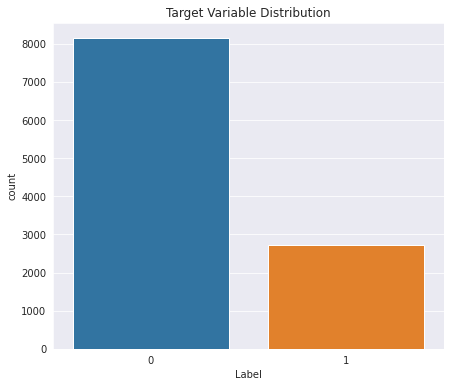

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize=(7, 6))
sns.countplot(x= train.Label)
plt.title('Target Variable Distribution')
plt.show()

The dataset is highly imbalanced with the majority class having 75% and the minority class 25%

We experiment with both using SMOTE and giving a larger weight to the minorty class observtions. In the end, it seems like SMOTE works best for us and thus we use this method in the final deliverable


<a name = "Outliers"></a>
## 7. Outliers

In [ ]:
# Exploring some features for cell 1
explore_cols =  ['1_elevation', '1_aspect', '1_slope', '1_placurv', '1_procurv', '1_lsfactor', '1_twi', '1_sdoif']
explore_cols

['1_elevation',
 '1_aspect',
 '1_slope',
 '1_placurv',
 '1_procurv',
 '1_lsfactor',
 '1_twi',
 '1_sdoif']

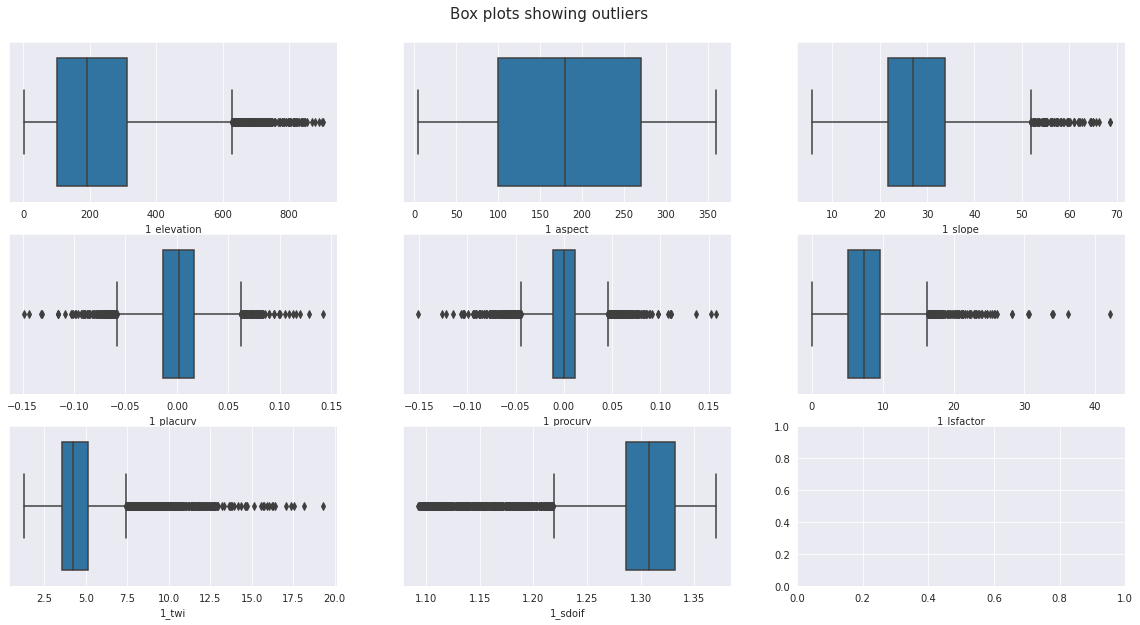

In [ ]:
# Plotting boxplots for each of the numerical columns
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (20, 10))
fig.suptitle('Box plots showing outliers', y= 0.93, fontsize = 15)

for ax, data, name in zip(axes.flatten(), train, explore_cols):
  sns.boxplot(train[name], ax = ax)

 Elevation, IsFactor, Placurv, curve and slope have some outliers.
 The aspect feature has no outliers.

### Preprocessing

In [ ]:
main_cols = train.columns.difference(['Sample_ID', 'Label'])
X = train[main_cols].copy()

In [ ]:
scaler = StandardScaler()

In [ ]:
y = train.Label              

In [ ]:
def remove_outliers(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    for i in df.columns:
        a =((df[i].values<(Q1[i]-1.5*IQR[i])) | (df[i].values>(Q3[i]+1.5*IQR[i])))
        df.loc[((df[i]<(Q1[i]-1.5*IQR[i])) | (df[i]>(Q3[i]+1.5*IQR[i]))), i] = df[i].median()
    return df

In [ ]:
#function doing the whole preprocessing: 
# - get mae score of difference between values and middle point (where the drift happens)
# - deal with outliers (log),
# - take interaction between features
# - take mode for categorical variable and consider only one
# - standardize all features
# - divide elevation variable into bins
def preprocessing(df,scale=False):
    #we perform difference between value and 13 (middle point)
    columns=['elevation','slope','aspect','placurv','procurv','lsfactor','twi','sdoif']

    for j,row in df.iterrows():
        for i in columns:
            middle_value = row["13_" +i] 
            df.loc[j,"midpointdistMAE_"+i] = np.array([ abs(row[str(k)+"_" + i] - middle_value) for k in range(1,26) if k != 13]).mean()
            
    #we drop geology
    geology_col = [col for col in df.columns if col.endswith('geology')]
    df["geology_mode"] = df[geology_col].transpose().mode().transpose()[0]
    df.drop(columns=geology_col,inplace=True)


    #log elevation column to deal with outliers! (included these many columns because all of them contain a bit of outliers
    columns_to_log = ["elevation","lsfactor","placurv","aspect","twi","lsfactor"]
    for i in df.columns:
        if i in columns_to_log:#endswith("elevation"):
            df[i] = df[i].map(lambda x: np.log(x) if x > 0 else 0)

    
    #we need to do this division because then we ned to perform standardization
    categorical = [i for i in df.columns if i.endswith('geology_mode')]
    numeric = [ i for i in df.columns if not i.endswith('geology_mode')]
    if not scale:
        X_numeric_std = pd.DataFrame(data=scaler.fit_transform(df[numeric]), columns=numeric)
    else:
        X_numeric_std = pd.DataFrame(data=scaler.transform(df[numeric]), columns=numeric)
    
    
    #build polynomials interaction only, without bias term (1s..) of the variable lsfactor and slope
    poly = PolynomialFeatures(interaction_only=True,include_bias=False)

    df_poly = pd.DataFrame()
    for j in range(1,26):
        x = poly.fit_transform(X_numeric_std[[str(j)+'_lsfactor',str(j)+'_slope']])
        df_1 = pd.DataFrame()
        df_1[str(j) + "_lsfactor"], df_1[str(j)+"_slope"], df_1[str(j)+"_lsfac_slope"] = x.T
        if df_poly.empty:
            df_poly = pd.concat([df_1[str(j) + "_lsfactor"],df_1[str(j) + "_slope"], df_1[str(j)+"_lsfac_slope"]],axis=1)
        else:
            df_poly = pd.concat([df_poly,pd.concat([df_1[str(j) + "_lsfactor"],df_1[str(j) + "_slope"], df_1[str(j)+"_lsfac_slope"]],axis=1)],axis=1)
        X_numeric_std.drop(columns=[str(j)+'_lsfactor',str(j)+'_slope'],inplace=True)

    
    #merge everything
    X_numeric_std_with_poly = pd.merge(X_numeric_std,df_poly,left_index=True,right_index=True)
    X_std = pd.merge(X_numeric_std_with_poly, df[categorical], left_index=True, right_index=True)
    
    #divide elevation variable into bins!
    for i in X_std .columns:
        if i.endswith('elevation'):
            X_std [i] = X_std [i].apply(lambda x: 0 if x > 0 and x <= 100 else 1 if x > 100 and x <=200 else 2 if x > 200 and x <=300 else 3)
    return X_std
    

In [ ]:
#function performing interaction between features
def interaction(X_numeric_std,cols):
    poly = PolynomialFeatures(interaction_only=True,include_bias=False)
    df_poly = pd.DataFrame()
    for j in range(1,26):
        x = poly.fit_transform(X_numeric_std[[str(j)+'_'+cols[0],str(j)+'_'+cols[1]]])
        df_1 = pd.DataFrame()
        df_1[str(j) + '_'+cols[0]], df_1[str(j)+'_'+cols[1]], df_1[str(j)+'_'+cols[0]+'_'+cols[1]] = x.T
        if df_poly.empty:
            df_poly = pd.concat([df_1[str(j) + '_'+cols[0]],df_1[str(j) + '_'+cols[1]], df_1[str(j)+'_'+cols[0]+'_'+cols[1]]],axis=1)
        else:
            df_poly = pd.concat([df_poly,pd.concat([df_1[str(j) + '_'+cols[0]],df_1[str(j) + '_'+cols[1]], df_1[str(j)+'_'+cols[0]+'_'+cols[1]]],axis=1)],axis=1)
        X_numeric_std.drop(columns=[str(j) + '_'+cols[0],str(j) + '_'+cols[1]],inplace=True)

    X_numeric_std_with_poly = pd.merge(X_numeric_std,df_poly,left_index=True,right_index=True)
    return X_numeric_std_with_poly

In [ ]:
#we oversample because of unbalanced class (undersample was tried but didnt give the expected results)
oversample = SMOTE(random_state=42)

X, y = oversample.fit_resample(X, y)

In [ ]:
X_processed = preprocessing(X)

In [ ]:
#tried more interactions but ended up without expected results, no good impact on predictions.
#X_processed = interaction(X_processed,['aspect','elevation'])
#X_processed = interaction(X_processed,['slope','aspect'])
#X_processed = interaction(X_processed,['placurv','slope'])
#X_processed = interaction(X_processed,['placurv','aspect'])
#X_processed = interaction(X_processed,['slope','lsfactor'])
#X_processed = interaction(X_processed,['slope','twi'])
#X_processed = interaction(X_processed,['slope','sdoif'])
#X_processed= interaction(X_processed,['slope','placurv'])

<a name = "Model"></a>
## 9. LightGBM hyperparameter tuning

In [ ]:
def objective(trial, X, y):
    param_grid = {
        #         "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "max_bin": trial.suggest_int("max_bin", 200, 300),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15)
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2022)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lightgbm.LGBMClassifier(objective="binary", class_weight='balanced', **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            early_stopping_rounds=100,
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=20)

[I 2022-03-25 08:32:03,725] A new study created in memory with name: LGBM Classifier


[1]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[3]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[4]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[5]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[6]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[7]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[8]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[9]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[10]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[11]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[12]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[13]	valid_0's binary_logloss: 0.693147	valid_

[I 2022-03-25 08:32:09,495] Trial 0 finished with value: 0.6931471805656861 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21997364020792456, 'num_leaves': 2380, 'max_depth': 9, 'min_data_in_leaf': 8000, 'max_bin': 299, 'lambda_l1': 45, 'lambda_l2': 75, 'min_gain_to_split': 0.5699014254836393}. Best is trial 0 with value: 0.6931471805656861.


[73]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[74]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[75]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[76]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[77]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[78]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[79]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[80]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[81]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[82]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[83]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[84]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[85]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[86]	valid_0's binary_log

[I 2022-03-25 08:32:16,930] Trial 1 finished with value: 0.6931471805656861 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1746229992196878, 'num_leaves': 600, 'max_depth': 10, 'min_data_in_leaf': 8500, 'max_bin': 253, 'lambda_l1': 80, 'lambda_l2': 75, 'min_gain_to_split': 3.881867856861832}. Best is trial 0 with value: 0.6931471805656861.


[1]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[3]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[4]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[5]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[6]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[7]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[8]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[9]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[10]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[11]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[12]	valid_0's binary_logloss: 0.693147	valid_0's binary_logloss: 0.693147
[13]	valid_0's binary_logloss: 0.693147	valid_

In [ ]:
print(f"\tBest value (logloss): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (logloss): 0.33275
	Best params:
		n_estimators: 10000
		learning_rate: 0.08188023969608149
		num_leaves: 2280
		max_depth: 10
		min_data_in_leaf: 300
		max_bin: 236
		lambda_l1: 0
		lambda_l2: 40
		min_gain_to_split: 0.20946541853040712
		bagging_fraction: 0.9
		bagging_freq: 1
		feature_fraction: 0.9


We now use Kfold cross-validation to find the optimal threshold to compute the final output

In [ ]:
from sklearn.model_selection import KFold

# Train model
kf = KFold(n_splits=5, random_state=None, shuffle=False)
kf.get_n_splits(X)

f1_overall= []
X_processed = X_processed.to_numpy()

for train_index, test_index in kf.split(X_processed):
    X_train, X_test = X_processed[train_index], X_processed[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = lightgbm.LGBMClassifier(n_estimators= 10000, learning_rate= 0.08188023969608149, num_leaves= 2280, max_depth= 10, min_data_in_leaf= 300,
                                max_bin = 236, lambda_l1= 0, lambda_l2= 40)
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)
    f1_temp =[]
    for i in range(1, 100):
      y_pred = (y_prob[:,1]*100 > i)*1
      f1_temp.append(f1_score(y_test, y_pred))

    f1_overall.append(f1_temp)


In [ ]:
f1_socres = np.array(f1_overall[0]).reshape(99,10, order='F')

In [ ]:
final_f1 = np.mean(f1_socres, axis=1)

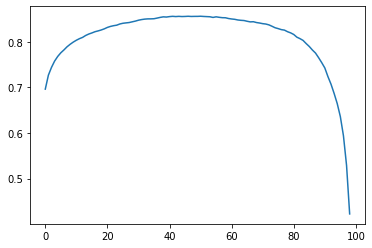

In [ ]:
plt.plot(final_f1)


In [ ]:
opt_threshod = np.argmax(final_f1)

### Model training

In [ ]:
#I used pycaret library to find the most performant model and ended up LGBMClssifier give best results.

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_processed,y,test_size=0.1, random_state=150)

# Train model (these hyperparameters have been found through cross validation, code not included here)
model = lightgbm.LGBMClassifier(learning_rate=0.1,max_depth=-1,n_estimators=260,min_child_samples=41,min_data_in_leaf=100,num_leaves = 70,reg_alpha=2,reg_lambda=7,random_state=200)
model.fit(X_train, y_train)

# Make predictions

#Because of the unbalancy we lower the treshold and try with various numbers

predicted_proba = model.predict_proba(X_test)
y_pred = (predicted_proba [:,1] >= opt_threshod).astype('int')


# Check the f1score of the model
print(f'LGBMClassifier F1 score on the X_test is: {f1_score(y_test, y_pred)}\n')

print(classification_report(y_test, y_pred))

In [ ]:
#predict (need first to preprocess the test!)

test_df = test[main_cols].copy()
test_df_processed = preprocessing(test_df,scale=True)

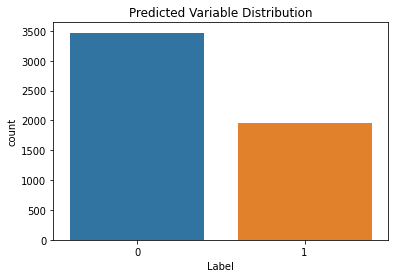

In [ ]:
model = lightgbm.LGBMClassifier(learning_rate=0.1,max_depth=-1,n_estimators=260,min_child_samples=41,min_data_in_leaf=100,num_leaves = 70,reg_alpha=2,reg_lambda=7,random_state=200)
model.fit(X_processed, y)

threshold = 0.33
predicted_proba = model.predict_proba(test_df_processed)
predictions = (predicted_proba [:,1] >= threshold).astype('int')

# Create a submission file
sub_file = pd.DataFrame({'Sample_ID': test.Sample_ID, 'Label': predictions})

# Check the distribution of your predictions
sns.countplot(x = sub_file.Label)
plt.title('Predicted Variable Distribution');

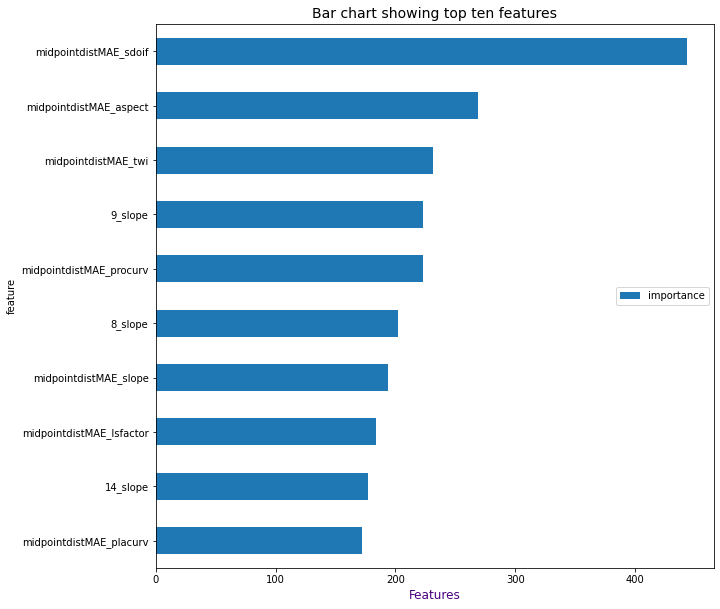

In [ ]:
# Feature importance
impo_df = pd.DataFrame({'feature': X_processed.columns, 'importance': model.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:10].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 10))
plt.legend(loc = 'center right')
plt.title('Bar chart showing top ten features', fontsize = 14)
plt.xlabel('Features', fontsize = 12, color = 'indigo')
plt.show()

<a name = "Submission"></a>
## 11. Creating a submission file

In [ ]:
# Create a csv file and upload to zindi 
sub_file.to_csv('Baseline.csv', index = False)
sub_file.head()

,Sample_ID,Label
0,10865,0
1,10866,0
2,10867,0
3,10868,1
4,10869,1


### Appendix

In [ ]:
s = setup(pd.merge(X_processed,y,left_index=True,right_index=True), target = 'Label',normalize=True)

In [ ]:
best = compare_models()

<a name = "Tips"></a>
## Convolutional Neural Network (CNN)

In [ ]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, BCELoss
from torch.optim import Adam, SGD 
from sklearn.metrics import f1_score
import tensorflow as tf
from torch import flatten

In [ ]:
# Read files to pandas dataframes
train = pd.read_csv('UNEP-STARTHACK22/Dataset/Train.csv')
test = pd.read_csv('UNEP-STARTHACK22/Dataset/Test.csv')
sample_submission = pd.read_csv('UNEP-STARTHACK22/Dataset/Sample submission.csv')

In [ ]:
categorical_var = [col for col in train.columns if col.endswith('geology')] + ['Sample_ID', 'Label']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_num = scaler.fit_transform(train.drop(categorical_var, axis=1))

In [ ]:
# Split label and variables
# X = train.drop(['Sample_ID', 'Label'], axis = 1) # ignore sample id and label
X = train_num.copy()
y = train['Label']

# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=2022)
print(X_train.shape)
# reshape x to numpy grid 9 x 5 x 5
train_x_reshaped = X_train.reshape((X_train.shape[0],  8, 5,5))
test_x_reshaped = X_test.reshape((X_test.shape[0],  8, 5,5))
# convert y
train_y_reshaped = y_train.to_numpy()
test_y_reshaped = y_test.to_numpy()
train_x_reshaped.shape, train_y_reshaped.shape, test_x_reshaped.shape, test_y_reshaped.shape


(9777, 200)


((9777, 8, 5, 5), (9777,), (1087, 8, 5, 5), (1087,))

In [ ]:
# convert to torch
train_x = torch.from_numpy(train_x_reshaped)
train_y = torch.from_numpy(train_y_reshaped)

test_x = torch.from_numpy(test_x_reshaped)
test_y = torch.from_numpy(test_y_reshaped)

train_x.shape, train_y.shape, test_x.shape, test_y.shape

(torch.Size([9777, 8, 5, 5]),
 torch.Size([9777]),
 torch.Size([1087, 8, 5, 5]),
 torch.Size([1087]))

In [ ]:
from torch.utils.data import Dataset, DataLoader

class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.tensor(x,dtype=torch.float32)
    self.y = torch.tensor(y,dtype=torch.float32)
    self.length = self.x.shape[0]
 
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]

  def __len__(self):
    return self.length

trainset = dataset(train_x,train_y)
trainloader = DataLoader(trainset,batch_size=64,shuffle=True)

valset = dataset(test_x,test_y)
valloader = DataLoader(valset,batch_size=64,shuffle=False)

In [ ]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        # def weight_reset(m):
        #   if isinstance(m, Conv2d) or isinstance(m, Linear):
        #     m.reset_parameters()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(in_channels = 8, out_channels = 32, kernel_size=(3,3), stride=1, padding=1),
            Dropout(p=0.2),
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=(2,2), stride=1),

            # Defining a 2D convolution layer
            Conv2d(in_channels = 32, out_channels = 64, kernel_size=(3,3), stride=1, padding=1),
            Dropout(p=0.2),
            BatchNorm2d(64),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=(2,2), stride=1),

            # Defining a 2D convolution layer
            # Conv2d(in_channels = 64, out_channels = 128, kernel_size=(3,3), stride=1, padding=1),
            # Dropout(p=0.3),
            # # BatchNorm2d(128),
            # ReLU(inplace=True),
            # MaxPool2d(kernel_size=(2,2), stride=1),              


        )

        self.linear_layers = Sequential(
            Linear(64*9,64),
            Dropout(p=0.2),
            Linear(64, 1)
        )

        # model.apply(weight_reset)

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = flatten(x, 1)
        x = self.linear_layers(x)
        x = torch.sigmoid(x)
        return x

In [ ]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.0005, weight_decay=1e-2, betas=(0.95, 0.99))
# defining the loss function
criterion = BCELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Dropout(p=0.2, inplace=False)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=(2, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Dropout(p=0.2, inplace=False)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=(2, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1152, out_features=64, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [ ]:
def train(epoch):
    model.train()

    training_loss = []
    valid_loss = []
    accuracy = 0.0
    outputs = []

    tr_loss = 0
    # getting the training set
    for data, target in trainloader:
      data, target = Variable(data), Variable(target)
      if torch.cuda.is_available():
        data = data.cuda()
        target = target.cuda()
      optimizer.zero_grad()
      output_train = model(data.float())
      train_loss = criterion(output_train,torch.reshape(target,(-1,1)).float())
      training_loss.append(train_loss)
      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()

    correct=0
    total=0
    true_output = []
    predicted_output = []

    for val_data, val_target in valloader:
      val_data, val_target = Variable(val_data), Variable(val_target)
      if torch.cuda.is_available():
        val_data = val_data.cuda()
        val_target = val_target.cuda()
      output_val = model(val_data.float())
      outputs.append(output_val)

      true_output.extend(val_target.cpu().data.numpy().flatten())

      val_loss = criterion(output_val, torch.reshape(val_target,(-1,1)).float())
      valid_loss.append(val_loss)
      predicted = (output_val > 0.35) * 1

      predicted_output.extend(predicted.cpu().data.numpy().flatten()) 

      total += val_target.size(0)
      correct += (predicted == torch.reshape(val_target, (-1, 1))).sum().item()

    accuracy = correct/total
    

    if (epoch%20==0) & (epoch!=0):
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', sum(valid_loss)/len(valid_loss))
        # print("Correctly predicted test: {}".format(test_correct/len(test_predictions)))
        # print("Correctly predicted train: {}".format(train_correct/len(train_predictions)))
        print("Acc Test:{}".format(accuracy))
        print("F1 Test:{}".format(f1_score(true_output, predicted_output)))

In [ ]:
# defining the number of epochs
n_epochs = 121

# training the model
for epoch in range(n_epochs):

    train(epoch)

In [ ]:
categorical_var_test = [col for col in test.columns if col.endswith('geology')] + ['Sample_ID']

In [ ]:
test_np = scaler.transform(test.drop(categorical_var, axis=1))

In [ ]:
# shape test data
# s_test_x = test.drop(['Sample_ID'], axis = 1)
s_test_x_reshaped = test_np.reshape((test_np.shape[0],  8, 5,5))
s_test_x = torch.from_numpy(s_test_x_reshaped)

# apply model
if torch.cuda.is_available():
  s_test_x = s_test_x.cuda()
output_test = model(s_test_x.float())

# compute predictions
predictions = (output_test > 0.4) *1
predictions = np.reshape(predictions.cpu().detach().numpy(), -1) # reshape
df = np.array([test['Sample_ID'], predictions])
df = np.transpose(df)

df = pd.DataFrame(data = df)
df.columns = ["ID", "label"]
df.to_csv("test.csv", index = False)

In [ ]:
print(correct)
print(len(test_y))

52558
1087


#                       ::GOOD LUCK AND HAPPY HACKING 😊


